In [4]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

# Sneak peek at the dataset

In [5]:

df = pd.read_csv('googleplaystore.csv')

#print(df.dtypes)
#df.loc[df.App=='Tiny Scanner - PDF Scanner App']
# df[df.duplicated(keep='first')]
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']

#print(len(df))

In [6]:
print('Number of apps in the dataset : ' , len(df))
df.sample(7)

Number of apps in the dataset :  9659


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4782,Flight Simulator X 2016 Free,FAMILY,3.8,44636,Varies with device,"1,000,000+",Free,0,Everyone,Simulation,"January 23, 2017",Varies with device,Varies with device
7219,CCleaner,TOOLS,4.4,885187,22M,"50,000,000+",Free,0,Everyone,Tools,"July 19, 2018",4.7.0,4.1 and up
855,Netflix,ENTERTAINMENT,4.4,5456208,Varies with device,"100,000,000+",Free,0,Teen,Entertainment,"July 31, 2018",Varies with device,Varies with device
9090,Triceratops - Dino Robot,FAMILY,4.4,3032,30M,"1,000,000+",Free,0,Everyone,Casual,"December 18, 2017",1.2.3,4.0 and up
6796,Battery Notifier Pro BT,TOOLS,4.7,1363,1.6M,"10,000+",Paid,$2.59,Everyone,Tools,"June 7, 2017",2.5.18,1.6 and up
5802,The Vikings,GAME,4.4,15806,42M,"1,000,000+",Free,0,Teen,Arcade,"June 6, 2018",1.0.7,4.1 and up
6550,Bubble Bo-Bo,FAMILY,4.5,65,24M,"10,000+",Free,0,Everyone,Casual,"July 5, 2018",6.0,4.0 and up


## Data Cleaning
 - Convert all app sizes to MB
 - Remove '+' from 'Number of Installs' to make it numeric
 - Convert all review text to English language using Google Translator library

In [7]:

# - Installs : Remove + and ,

df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))
#print(type(df['Installs'].values))


In [8]:
# - Size : Remove 'M', Replace 'k' and divide by 10^-3
#df['Size'] = df['Size'].fillna(0)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)


df['Size'] = df['Size'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))
#df['Reviews'] = df['Reviews'].apply(lambda x: 'NaN' if int(x) == 0 else int(x))
#print(df.loc[df.Size == 0.713]) #index = 3384
#df.loc[df.col1 == '']['col2']

# 0 - Free, 1 - Paid
# df['Type'] = pd.factorize(df['Type'])[0]
#print(df.dtypes)

## Basic EDA

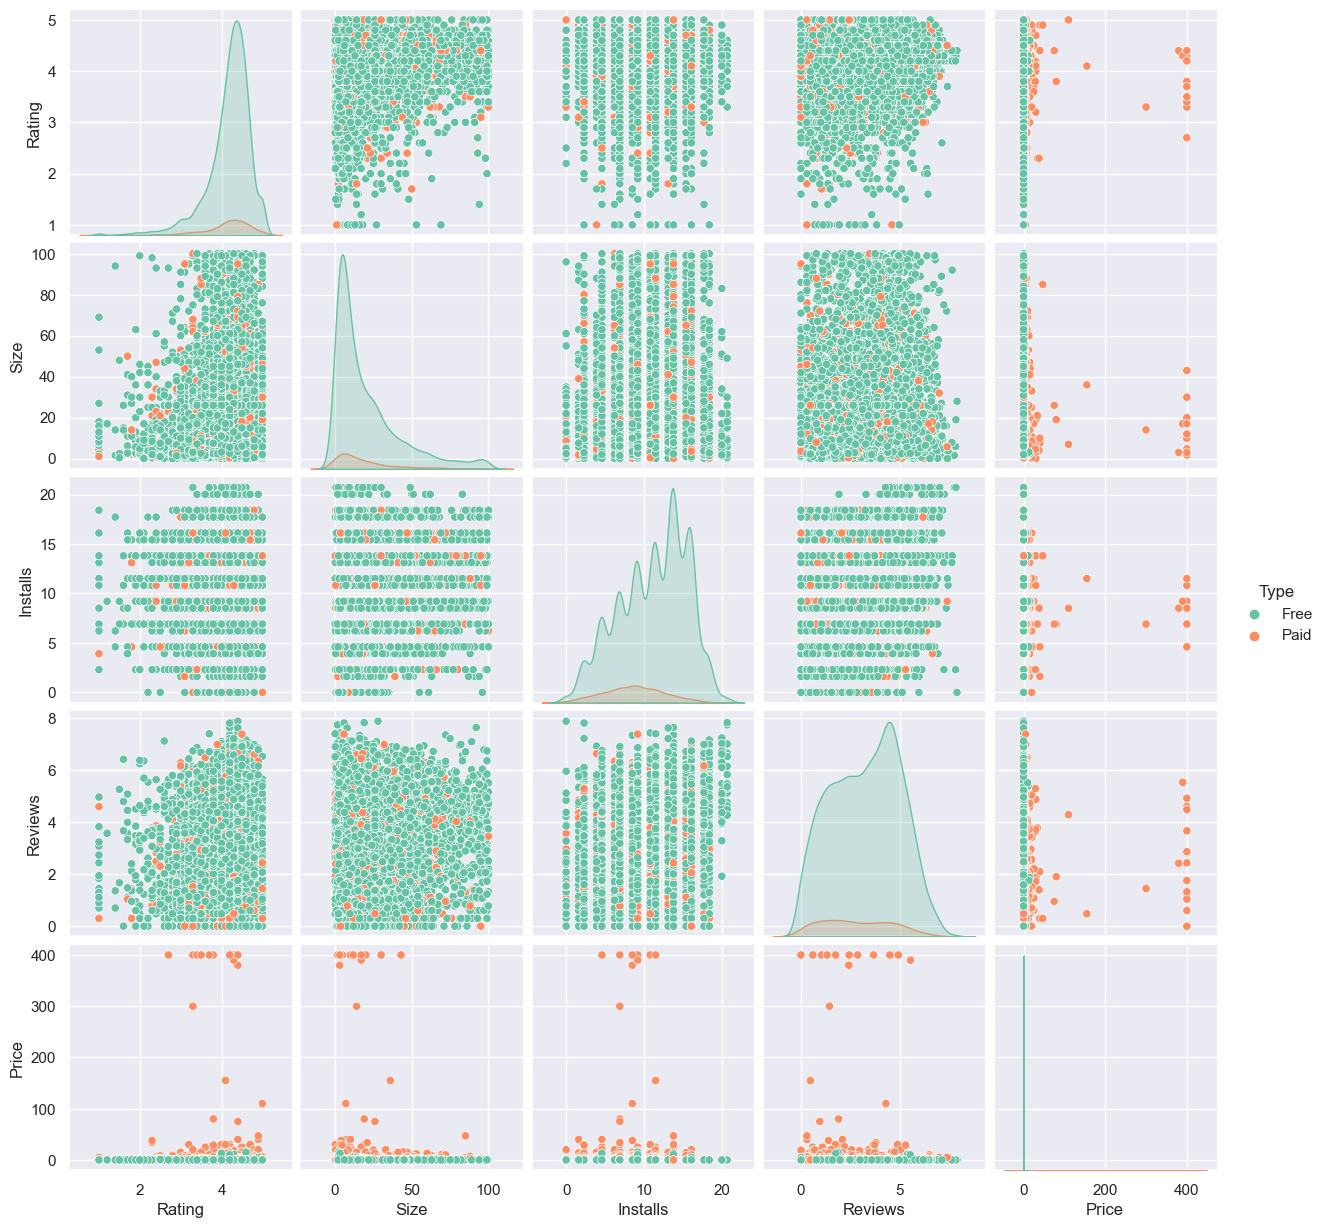

In [9]:
#print(df.dtypes)


x = df['Rating'].dropna()
y = df['Size'].dropna()
z = df['Installs'][df.Installs!=0].dropna()
p = df['Reviews'][df.Reviews!=0].dropna()
t = df['Type'].dropna()
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log(z), np.log10(p), t, price)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set2")

    This is the basic exploratory analysis to look for any evident patterns or relationships between the features. 

## Android market breakdown
Which category has the highest share of (active) apps in the market?

In [10]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

- **Family** and **Game** apps have the highest market prevelance. 
- Interestingly, **Tools, Business and Medical** apps are also catching up.

## Average rating of apps
Do any apps perform really good or really bad?

In [11]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.173243045387994


Generally, most apps do well with an average rating of **4.17**.

Let's break this down and inspect if we have categories which perform exceptionally good or bad.

## App ratings across categories - One Way Anova Test

F_onewayResult(statistic=12.79263715618054, pvalue=2.323280446259348e-20)

The p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.



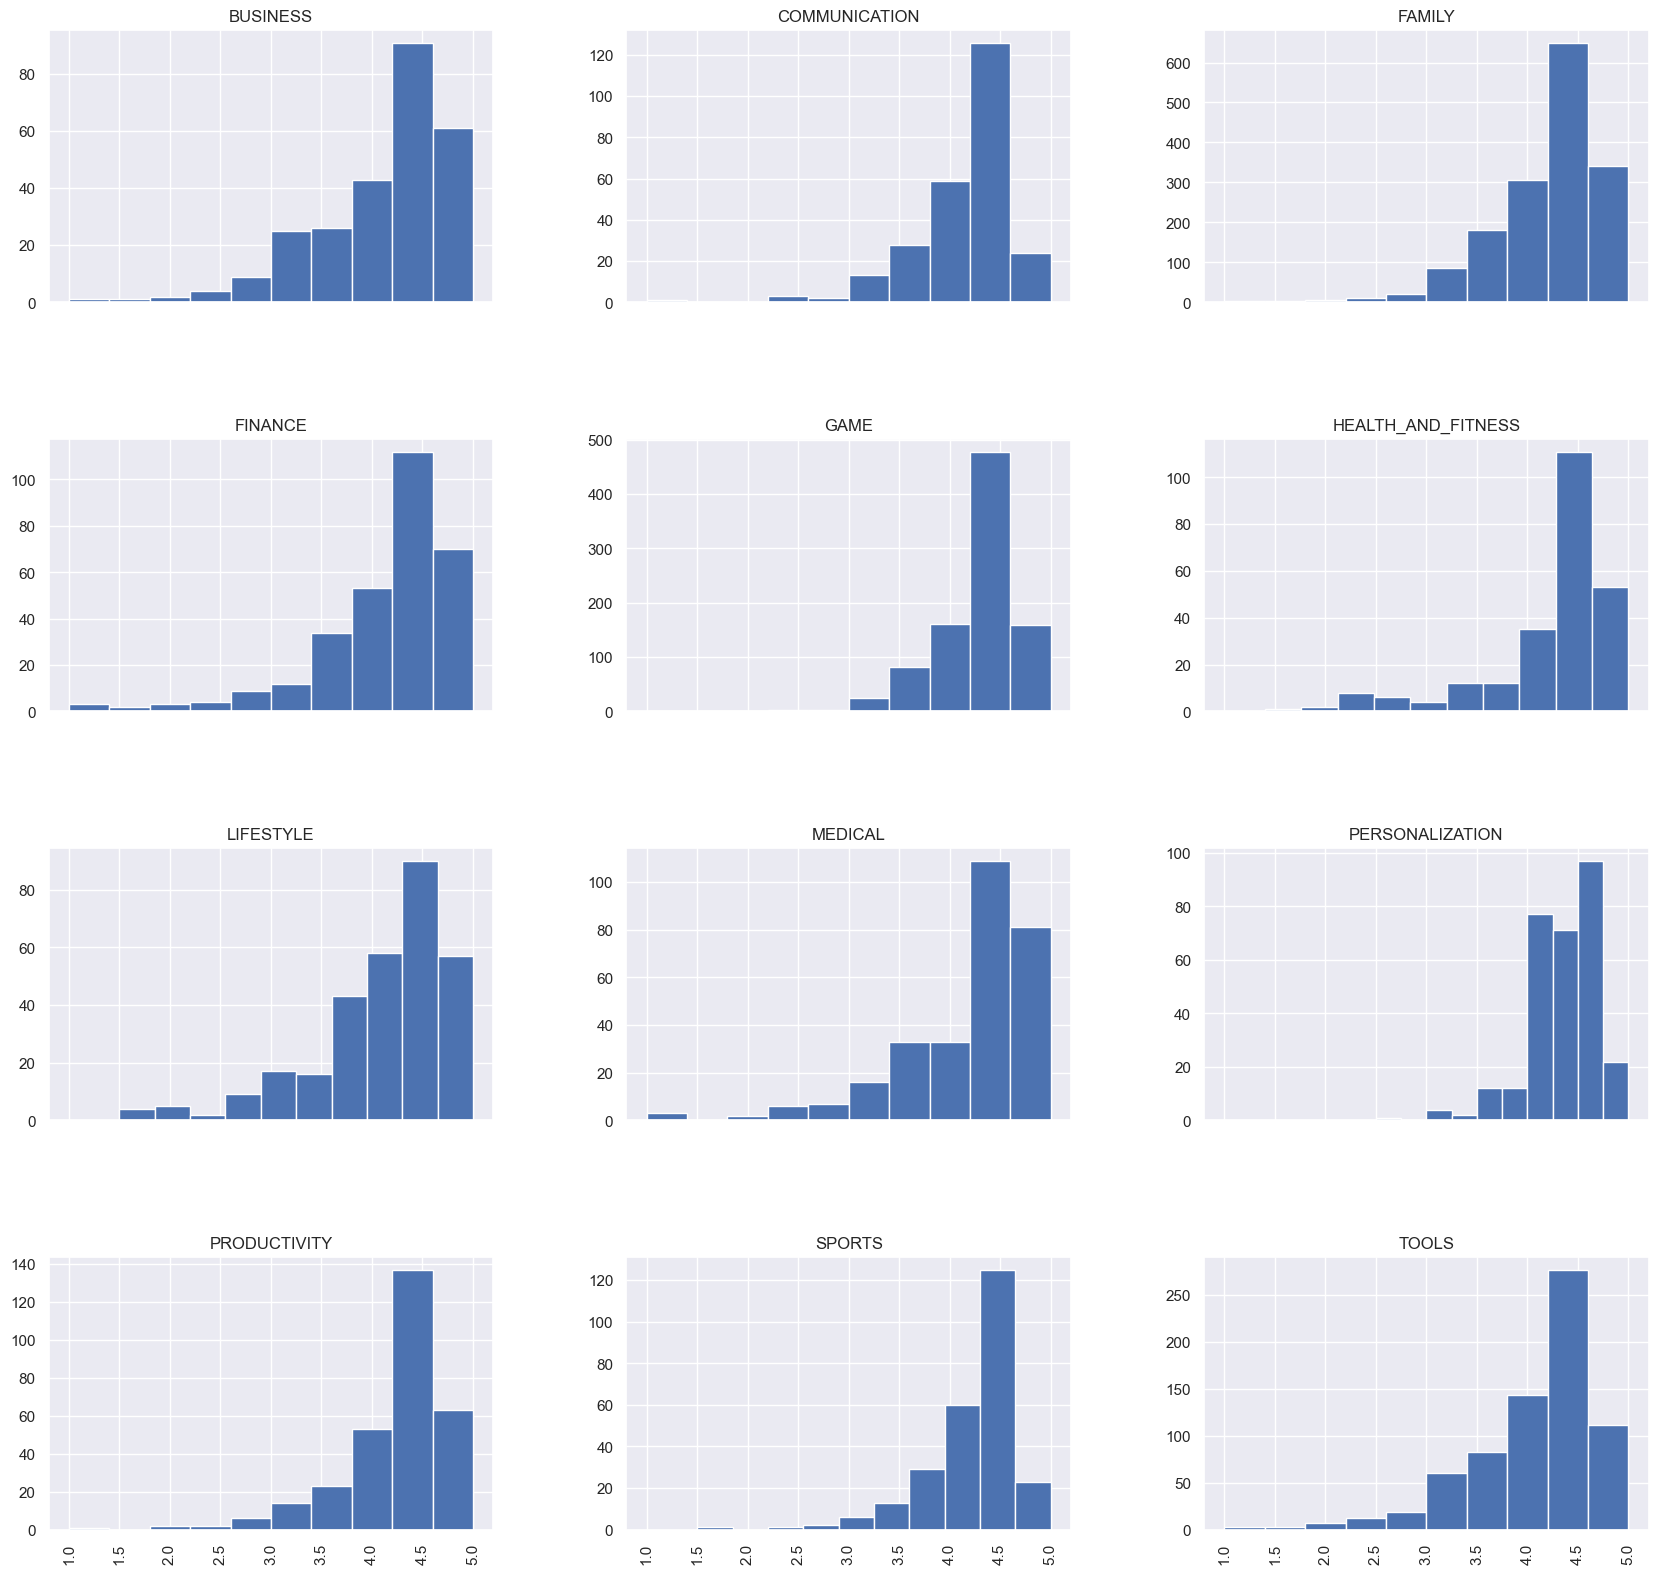

In [12]:
import scipy.stats as stats
f = stats.f_oneway(df.loc[df.Category == 'BUSINESS']['Rating'].dropna(), 
               df.loc[df.Category == 'FAMILY']['Rating'].dropna(),
               df.loc[df.Category == 'GAME']['Rating'].dropna(),
               df.loc[df.Category == 'PERSONALIZATION']['Rating'].dropna(),
               df.loc[df.Category == 'LIFESTYLE']['Rating'].dropna(),
               df.loc[df.Category == 'FINANCE']['Rating'].dropna(),
               df.loc[df.Category == 'EDUCATION']['Rating'].dropna(),
               df.loc[df.Category == 'MEDICAL']['Rating'].dropna(),
               df.loc[df.Category == 'TOOLS']['Rating'].dropna(),
               df.loc[df.Category == 'PRODUCTIVITY']['Rating'].dropna()
              )

print(f)
print('\nThe p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.\n')
#temp = df.loc[df.Category.isin(['BUSINESS', 'DATING'])]

groups = df.groupby('Category').filter(lambda x: len(x) > 286).reset_index()
array = groups['Rating'].hist(by=groups['Category'], sharex=True, figsize=(20,20))

                            The average app ratings across categories is significantly different.

## Best performing categories

In [13]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'App ratings across major categories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})



Average rating =  4.170026786973072



- Almost all app categories perform decently. **Health and Fitness** and **Books and Reference** produce the highest quality apps with **50% apps having a rating greater than 4.5.** This is extremely high!


- On the contrary, **50% of apps in the Dating category have a rating lesser than the average rating**. 


- A few **junk apps** also exist in the **Lifestyle**, **Family** and **Finance** category.


# Sizing Strategy - Light Vs Bulky?

How do app sizes impact the app rating?

In [14]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

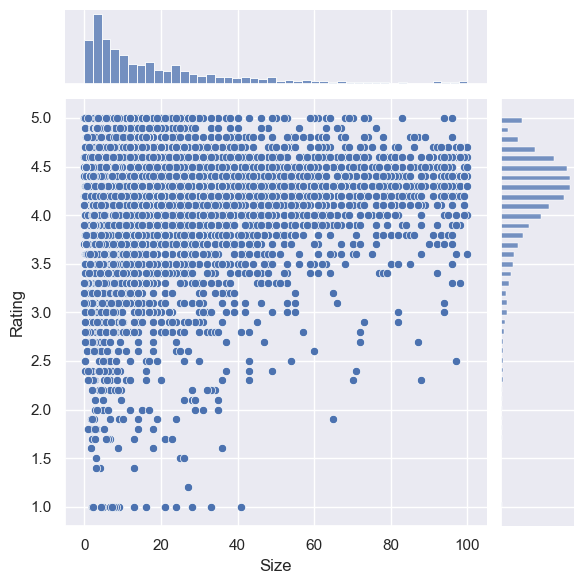

In [16]:
sns.set_style("darkgrid")
sns.jointplot(x='Size', y='Rating', data=df, kind='scatter')
plt.show()


Most top rated apps are optimally sized between **~2MB to ~40MB** - neither too light nor too heavy.

In [17]:

c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

# for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

# heavy_categories = [ 'ENTERTAINMENT', 'MEDICAL', 'DATING']

# data = [{
#     'x': groups.loc[df.Category==category]['Rating'], 
#     'type':'scatter',
#     'y' : df['Size'],
#     'name' : category,
#     'mode' : 'markers',
#     'showlegend': True,
#     #'text' : df['rating'],
#     } for category in heavy_categories]

Most bulky apps ( >50MB) belong to the **Game** and **Family** category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

# Pricing Strategy - Free Vs Paid?
How do app prices impact app rating?

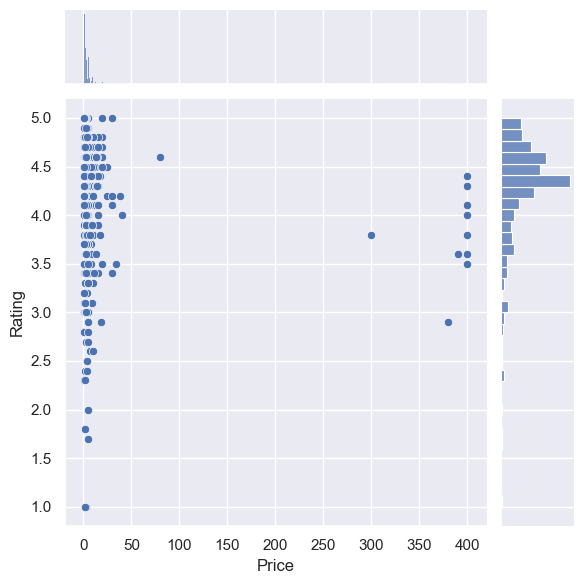

In [19]:
paid_apps = df[df['Price'] > 0]  # Filter for paid apps
sns.jointplot(x='Price', y='Rating', data=paid_apps, kind='scatter')
plt.show()


Most top rated apps are optimally priced between **~1\$ to ~30\$**. There are only a very few apps priced above 20\$.

## Current pricing trend - How to price your app?

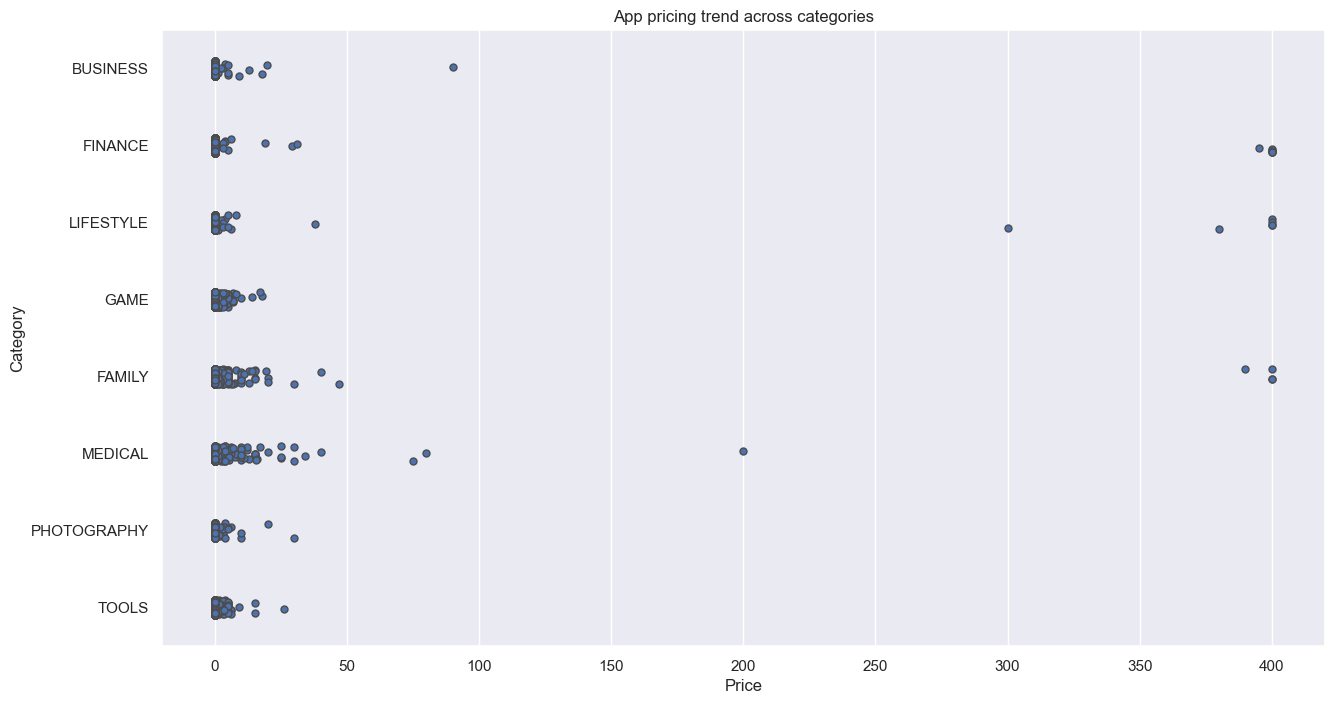

In [20]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories')


Shocking...Apps priced above 250\$ !!! Let's quickly examine what these junk apps are.

In [21]:
#print('Junk apps priced above 350$')
df[['Category', 'App']][df.Price > 200]

,Category,App
4197,FAMILY,most expensive app (H)
4362,LIFESTYLE,💎 I'm rich
4367,LIFESTYLE,I'm Rich - Trump Edition
5351,LIFESTYLE,I am rich
5354,FAMILY,I am Rich Plus
5355,LIFESTYLE,I am rich VIP
5356,FINANCE,I Am Rich Premium
5357,LIFESTYLE,I am extremely Rich
5358,FINANCE,I am Rich!
5359,FINANCE,I am rich(premium)


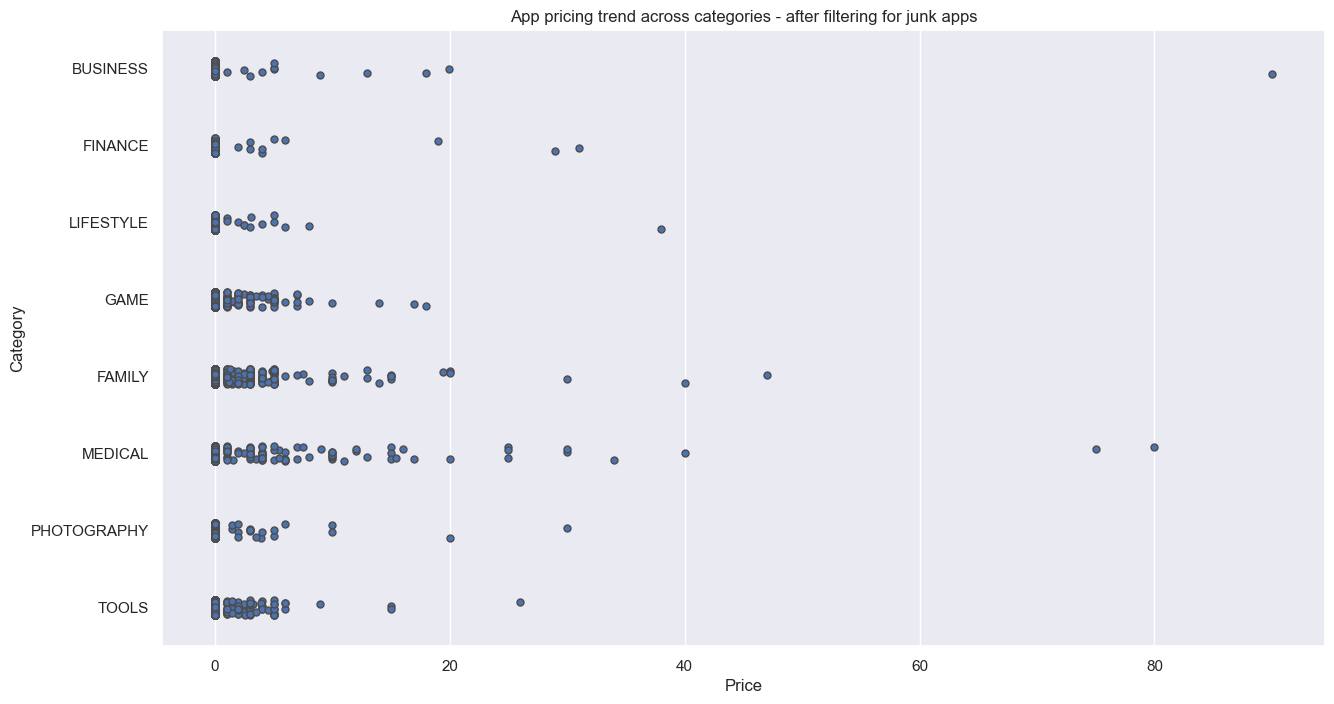

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = subset_df[subset_df.Price<100]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories - after filtering for junk apps')

- Clearly, **Medical and Family apps** are the most expensive. Some medical apps extend even upto 80\$.


- All other apps are priced under 30\$.


- Surprisingly, **all game apps are reasonably priced below 20\$.**

## Distribution of paid and free apps across categories

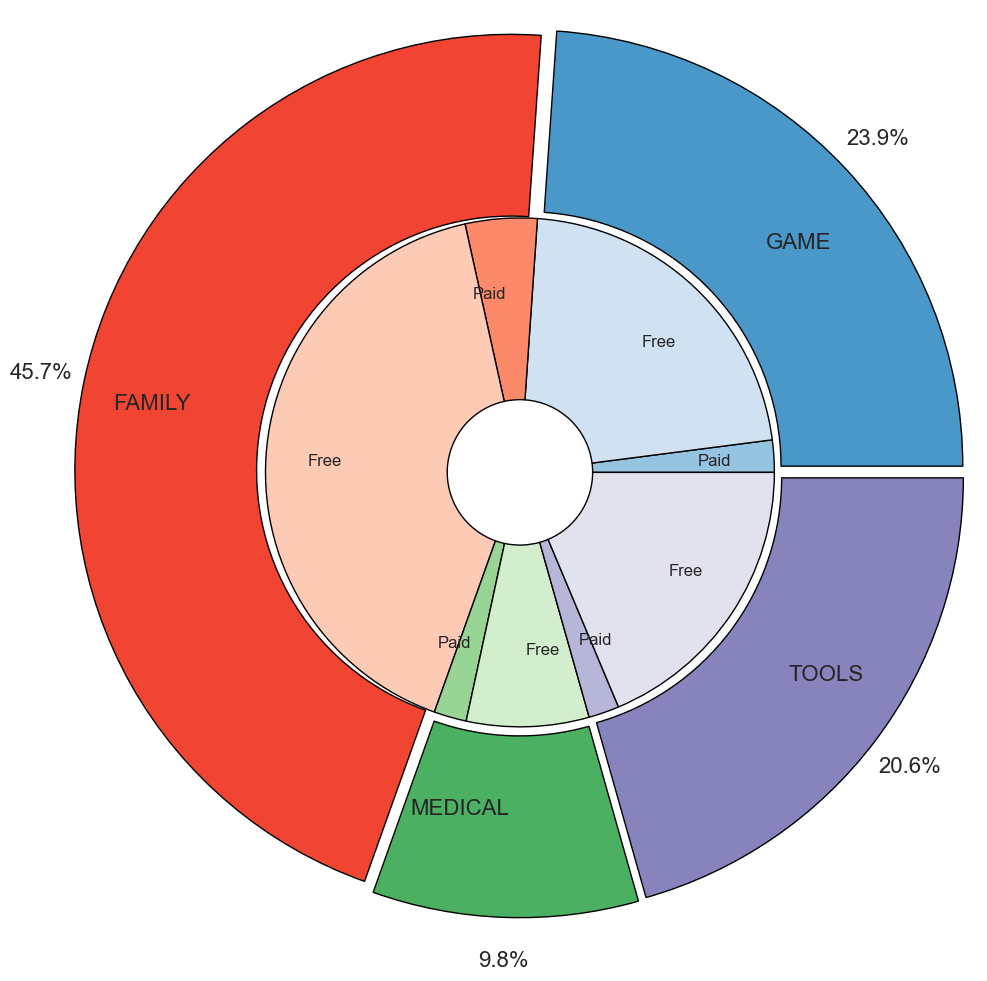

In [23]:
# Stacked bar graph for top 5-10 categories - Ratio of paid and free apps
#fig, ax = plt.subplots(figsize=(15,10))

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()
#print(new_df)

# outer_group_names = df['Category'].sort_values().value_counts()[:5].index
# outer_group_values = df['Category'].sort_values().value_counts()[:5].values

outer_group_names = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS']
outer_group_values = [len(df.App[df.Category == category]) for category in outer_group_names]

a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 4
inner_group_values = []
#inner_colors = ['#58a27c','#FFD433']


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(0)

explode = (0.025,0.025,0.025,0.025)
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.2, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6)], textprops={'fontsize': 16})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.2-0.5, labels=inner_group_names, labeldistance= 0.7, 
                   textprops={'fontsize': 12}, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()



#ax = sns.countplot(x="Category", hue="Type", data=new_df)

#df.groupby(['Category', 'Type']).count()['App'].unstack().plot(kind='bar', stacked=True, ax=ax)
#ylabel = plt.ylabel('Number of apps')



                    Distribution of free and paid apps across major categories

# Are paid apps downloaded as much as free apps?

In [24]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

**Paid apps have a relatively lower number of downloads than free apps.** However, it is not too bad.

# How do the sizes of paid apps and free apps vary?

In [25]:
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.Size > 5]
#type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

- **Majority of the paid apps that are highly rated have small sizes.** This means that most paid apps are designed and developed to cater to specific functionalities and hence are not bulky.


- **Users prefer to pay for apps that are light-weighted.** A paid app that is bulky may not perform well in the market.

# Exploring Correlations

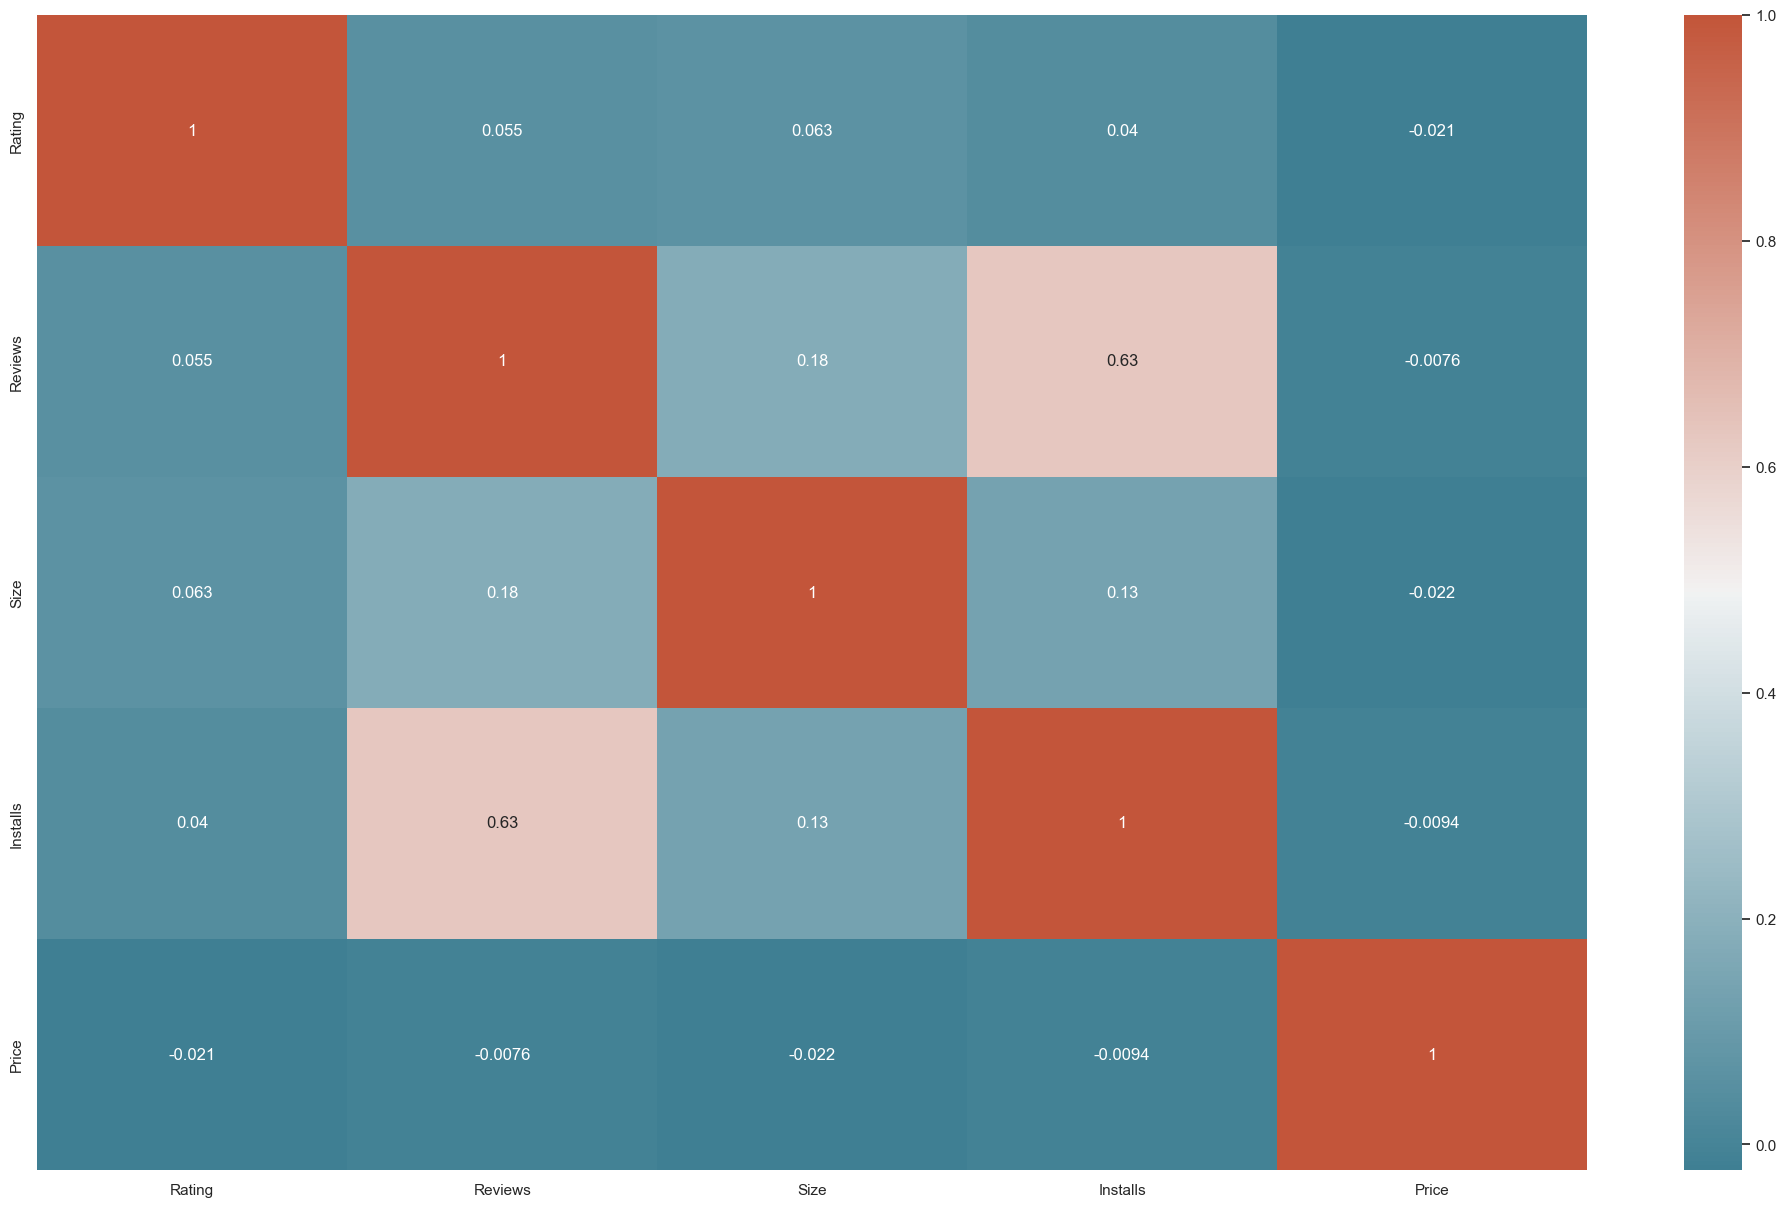

In [26]:
corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

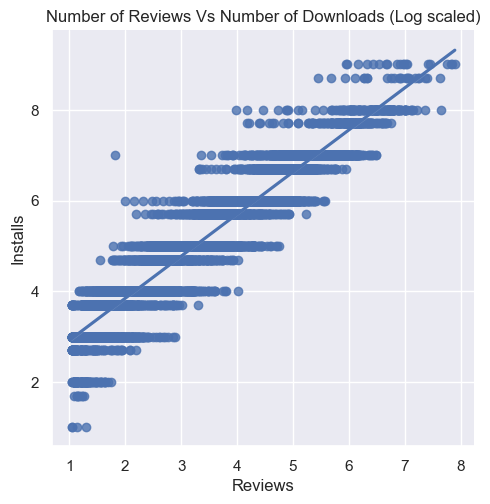

In [28]:
sns.lmplot(x="Reviews", y="Installs", data=df_copy)
ax = plt.gca()
ax.set_title('Number of Reviews Vs Number of Downloads (Log scaled)')
plt.show()


**A moderate positive correlation of 0.63 exists between the number of reviews and number of downloads.** This means that customers tend to download a given app more if it has been reviewed by a larger number of people. 

This also means that many active users who download an app usually also leave back a review or feedback. 

So, getting your app reviewed by more people maybe a good idea to increase your app's capture in the market!

# Basic Sentiment Analysis - User reviews 

In [29]:
reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')

In [30]:
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

In [31]:
grouped_sentiment_category_count = merged_df.groupby(['Category', 'Sentiment']).agg({'App': 'count'}).reset_index()
grouped_sentiment_category_sum = merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()

new_df = pd.merge(grouped_sentiment_category_count, grouped_sentiment_category_sum, on=["Category"])
#print(new_df)
new_df['Sentiment_Normalized'] = new_df.App/new_df.Sentiment_y
new_df = new_df.groupby('Category').filter(lambda x: len(x) ==3)
# new_df = new_df[new_df.Category.isin(['HEALTH_AND_FITNESS', 'GAME', 'FAMILY', 'EDUCATION', 'COMMUNICATION', 
#                                      'ENTERTAINMENT', 'TOOLS', 'SOCIAL', 'TRAVEL_AND_LOCAL'])]
new_df

trace1 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[::3][6:-5],
    name='Negative',
    marker=dict(color = 'rgb(209,49,20)')
)

trace2 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[1::3][6:-5],
    name='Neutral',
    marker=dict(color = 'rgb(49,130,189)')
)

trace3 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[2::3][6:-5],
    name='Positive',
    marker=dict(color = 'rgb(49,189,120)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Sentiment analysis',
    barmode='stack',
    xaxis = {'tickangle': -45},
    yaxis = {'title': 'Fraction of reviews'}
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot({'data': data, 'layout': layout})

- **Health and Fitness** apps perform the best, having more than **85% positive reviews**.


- On the contrary, many **Game and Social** apps perform bad leading to **50% positive and 50% negative**.

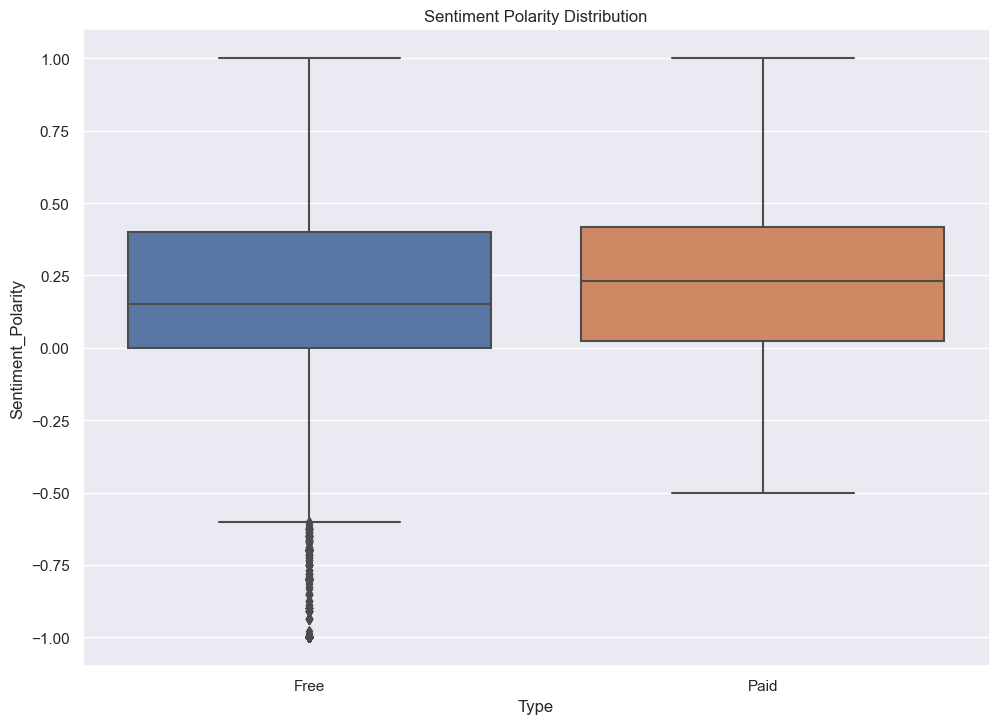

In [32]:
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

- **Free apps receive a lot of harsh comments** which are indicated as outliers on the negative Y-axis. 

- **Users are more lenient and tolerant while reviewing paid apps - moderate choice of words.** They are never extremely negative while reviewing a paid app. 

## WORDCLOUD - A quick look on Reviews


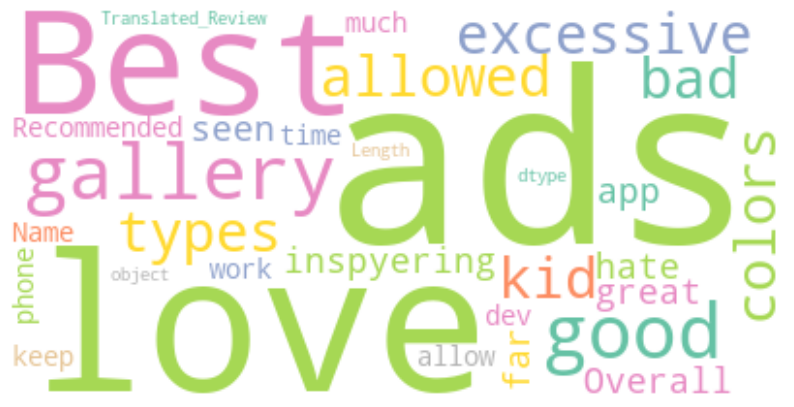

In [34]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=200, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

#merged_df = merged_df.dropna(subset=['Translated_Review'])
merged_df['Translated_Review'] = merged_df['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
#print(any(merged_df.Translated_Review.isna()))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
merged_df.dropna(subset=['Translated_Review'], inplace=True)


free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

  FREE APPS
> 
**Negative words: ads, bad, hate**
>
**Positive words: good, love, best, great**

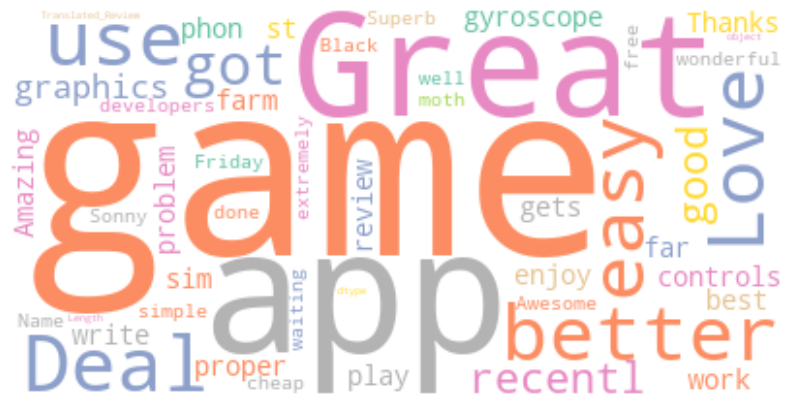

In [35]:
paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

   PAID APPS
> 
**Negative words: malware, problem**
>
**Positive words: great, love, easy**

# CONCLUSION

 The average rating of active apps on the Google Play Store is 4.17.

Users show a preference for lightweight paid apps. Bulky paid apps may struggle to perform well in the market.

The majority of top-rated apps are optimally sized between approximately 2MB and 40MB, striking a balance between being neither too small nor too large.

Top-rated apps are generally priced between $1 and $30, avoiding extremes of being too cheap or overly expensive.

Medical and Family apps are the most expensive categories, with prices reaching up to $80.

Apps with a higher number of reviews tend to attract more downloads, highlighting the importance of user feedback.

Health and Fitness apps receive overwhelmingly positive reviews, exceeding 85% positivity. In contrast, Game and Social apps garner mixed feedback, with approximately 50% positive and 50% negative reviews.

Users tend to be more critical when reviewing free apps compared to paid ones, reflecting harsher scrutiny for free offerings.